In [1]:
%matplotlib inline

In [3]:
import torch
import torch.nn as nn
import pandas as pd
from skimage import io
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import torch.optim as optim
import os
import torchvision.models as models

import pathlib
from torchvision.datasets import ImageFolder

import time
import torch
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image

from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

In [4]:
def set_seed(seed=None, seed_torch=True):
    if seed is None:
        seed = np.random.choice(2 ** 32)
    random.seed(seed)
    np.random.seed(seed)
    if seed_torch:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

    print(f'Random seed {seed} has been set.')

In [5]:
torch.cuda.empty_cache()

In [6]:
SEED = set_seed(seed=42, seed_torch=True)

Random seed 42 has been set.


In [7]:
def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

In [8]:
set_device()

GPU is not enabled in this notebook. 
If you want to enable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `GPU` from the dropdown menu


'cpu'

In [9]:
print(torch.cuda.is_available())

False


In [183]:
df_train = pd.read_csv('train.csv')
df_train

,id,label
0,068aba587a4950175d04c680d38943fd488d6a9d.tif,0
1,c2a8ef295e49b8012e5bc83917a305057eaa1932.tif,1
2,1bb23b52c53abdfb8105a5dda50bf6d5fa7b14fc.tif,0
3,50f157dd5878369b1ed0a9acc102fcee451b64d6.tif,0
4,2063372edcea465d2bea334a779462e74fbfb978.tif,1
...,...,...
4795,5937089e6ee8de52993856859560ae51e88a0263.tif,1
4796,863126f17c67c74f71900957dfb8cea54f8a32d9.tif,0
4797,f298d605661d859b65fbefc110d1dec72e533740.tif,0
4798,8414c562041804f1d08cb31d0e594a485f5e77cd.tif,1


In the original `train.csv` there are more no cancer (2920) than cancer (1880) images. The following code removes cancer images so that the number of cancer and no cancer images are the same.

In [184]:
label_dict = {0: 'nocancer', 1: 'cancer'}

In [185]:
label_counts = df_train.label.value_counts().rename(index=label_dict)
label_counts

nocancer    2920
cancer      1880
Name: label, dtype: int64

array([[<AxesSubplot:title={'center':'label'}>]], dtype=object)

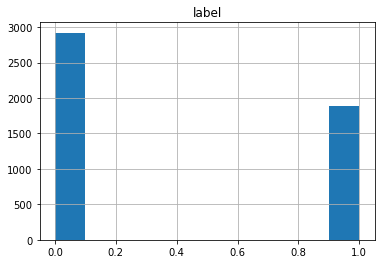

In [186]:
df_train.hist(column='label')

In [195]:
sum([df_id in os.listdir('train') for df_id in df_train['id']])

156

IndexError: index 0 is out of bounds for axis 0 with size 0

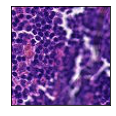

In [187]:
fig = plt.figure(figsize=(25, 4))
# display 20 images
train_imgs = os.listdir("train")
for idx, img in enumerate(np.random.choice(train_imgs, 20, replace=False)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open(os.path.join("train", img))
    plt.imshow(im)
    lab = df_train.loc[df_train['id'] == img, 'label'].values[0]
    ax.set_title(f'Label: {lab}')

In [ ]:
data_transforms_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
data_transforms_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [40]:
## split data into train and validation set
train_set, val_set = train_test_split(df_breast_cancer.label, stratify=df_breast_cancer.label, train_size=0.8)

In [158]:
df_train = df_breast_cancer
df_valid = df_breast_cancer

for index, row in df_breast_cancer.iterrows():
    if index not in train_set:
        df_train = df_train.drop(index)
    elif index in train_set:
        df_valid = df_valid.drop(index)
        
        

In [159]:
df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)

In [160]:
len(df_train), len(df_valid)

(4800, 1200)

In [47]:
df_valid.to_csv('/home/alex/nma project/dfs train_valid/valid.csv', index=False)

In [45]:
path = 

SyntaxError: invalid syntax (<ipython-input-45-50ca1fbcb4dd>, line 1)

In [70]:
df_train.to_excel('/home/alex/Downloads/dfs convnet/df_train.xlsx', index=False)

In [71]:
df_valid.to_excel('/home/alex/Downloads/dfs convnet/df_valid.xlsx', index=False)

In [50]:
path+'dfs train_valid/'

'/home/alex/nma project/dfs train_valid/'

In [24]:
root_dir = 'train/'

In [26]:
## load data
dataset_train = PathologyDataset(csv_file = 'train.csv', root_dir = root_dir, transform = data_transforms_train)
dataset_val = PathologyDataset(csv_file = 'valid.csv', root_dir = root_dir, transform = data_transforms_test)

In [27]:
batch_size = 256

train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)

In [22]:
class PathologyDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=ToTensor()):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.annotations) 
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index,0])
        image = Image.open(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
        
        if self.transform:
            image = self.transform(image)
            
        return(image, y_label)

In [28]:
resnet18 = models.resnet18(pretrained = False)
alexnet = models.alexnet(pretrained = False)

In [30]:
resnet18 = models.resnet18(pretrained = False)

In [31]:
alexnet = models.alexnet(pretrained = False)

In [32]:
import torch
from torch import Tensor
import torch.nn as nn
#from .._internally_replaced_utils import load_state_dict_from_url
from typing import Type, Any, Callable, Union, List, Optional


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
           'wide_resnet50_2', 'wide_resnet101_2']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-f37072fd.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-b627a593.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-0676ba61.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-63fe2227.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-394f9c45.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}


def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(self, block: Type[Union[BasicBlock, Bottleneck]], planes: int, blocks: int,
                    stride: int = 1, dilate: bool = False) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


def _resnet(
    arch: str,
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    pretrained: bool,
    progress: bool,
    **kwargs: Any
) -> ResNet:
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)


def resnet34(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet50(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet101(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-101 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], pretrained, progress,
                   **kwargs)


def resnet152(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-152 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress,
                   **kwargs)


def resnext50_32x4d(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNeXt-50 32x4d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 4
    return _resnet('resnext50_32x4d', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def resnext101_32x8d(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNeXt-101 32x8d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnet('resnext101_32x8d', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)


def wide_resnet50_2(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""Wide ResNet-50-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_.
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet50_2', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def wide_resnet101_2(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""Wide ResNet-101-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_.
    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet101_2', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)

In [80]:
import torch
import torch.nn as nn
#from torch.utils import load_state_dict_from_url
from typing import Any


__all__ = ['AlexNet', 'alexnet']


model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-7be5be79.pth',
}


class AlexNet(nn.Module):

    def __init__(self, num_classes: int = 1000) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(p = 0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


def alexnet(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> AlexNet:
    """AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = AlexNet(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['alexnet'],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


In [44]:
# Make a CNN & train it to predict genres.

class conv_net(nn.Module):
    def __init__(self):
        """Intitalize neural net layers"""
        super(conv_net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(in_features=3200, out_features=2)

        self.batchnorm1 = nn.BatchNorm2d(num_features=8)
        self.batchnorm2 = nn.BatchNorm2d(num_features=16)
        self.batchnorm3 = nn.BatchNorm2d(num_features=32)

        self.dropout = nn.Dropout(p=0.3, inplace=False)


    def forward(self, x):
        # Conv layer 1.
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        # Conv layer 2.
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        # Conv layer 3.
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        #print(x.shape)
        # Fully connected layer 1.
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = F.softmax(x)

        return x


def train(model, device, train_loader, validation_loader, epochs):
    
    preds = []
    
    accuracies_0 = []
    accuracies_1 = []

    criterion =  nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []
    with tqdm(range(epochs), unit='epoch') as tepochs:
        tepochs.set_description('Training')
        for epoch in tepochs:
            model.train()
            # keep track of the running loss
            running_loss = 0.
            correct, total = 0, 0

            for data, target in train_loader:
                # getting the training set
                #data = data.permute(0,3,1,2).float()
                data, target = data.to(device), target.to(device)
                #print(data.shape, target.shape)
                # Get the model output (call the model with the data from this batch)
                output = model(data)
                # Zero the gradients out)
                optimizer.zero_grad()
                # Get the Loss
                loss  = criterion(output, target)
                # Calculate the gradients
                loss.backward()
                # Update the weights (using the training step of the optimizer)
                optimizer.step()

                tepochs.set_postfix(loss=loss.item())
                running_loss += loss  # add the loss for this batch

                # get accuracy
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

            # append the loss for this epoch
            train_loss.append(running_loss/len(train_loader))
            train_acc.append(correct/total)

            # evaluate on validation data
            model.eval()
            running_loss = 0.
            correct, total = 0, 0

            targets = torch.zeros(0).to('cuda:0')
            
            preds = torch.zeros(0).to('cuda:0')
            
            for data, target in validation_loader:
                # getting the validation set
                #data = data.permute(0,3,1,2).float()
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                tepochs.set_postfix(loss=loss.item())
                running_loss += loss.item()
                # get accuracy
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

                targets = torch.cat((targets, target))
                
                preds = torch.cat((preds, predicted))
                
            validation_loss.append(running_loss/len(validation_loader))
            validation_acc.append(correct/total)
            
            rights_0 = []
            rights_1 = []


            t = targets

            for i in [preds[x].item() for x in [x.item() for x in ((t == 0).nonzero(as_tuple=True)[0])]]:
                rights_0.append(np.where((i == 0),1,0))

            acc_0 = sum(rights_0)/len(((t == 0).nonzero(as_tuple=True)[0]))

            for i in [preds[x].item() for x in [x.item() for x in ((t == 1).nonzero(as_tuple=True)[0])]]:
                rights_1.append(np.where((i == 1),1,0))

            acc_1 = sum(rights_1)/len(((t == 1).nonzero(as_tuple=True)[0]))
            
            accuracies_0.append(acc_0)
            accuracies_1.append(acc_1)

        

    return train_loss, train_acc, validation_loss, validation_acc, preds, targets, accuracies_0, accuracies_1

In [39]:
preds[:50]

NameError: name 'preds' is not defined

In [65]:
targets[:50]

tensor([0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
        0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1.],
       device='cuda:0')

In [67]:
t = targets

((t == 0).nonzero(as_tuple=True)[0])

tensor([   0,    1,    4,    5,    6,    7,    9,   11,   12,   13,   14,   15,
          18,   20,   22,   23,   24,   25,   27,   28,   31,   32,   33,   34,
          35,   38,   39,   40,   41,   42,   45,   46,   48,   54,   55,   56,
          57,   58,   59,   60,   61,   62,   63,   66,   67,   68,   69,   70,
          75,   76,   77,   80,   82,   83,   87,   91,   92,   97,   99,  102,
         103,  104,  105,  107,  109,  110,  111,  112,  113,  114,  116,  117,
         120,  124,  127,  129,  131,  132,  133,  134,  135,  136,  137,  139,
         142,  144,  146,  147,  150,  152,  153,  154,  155,  156,  157,  158,
         160,  162,  164,  167,  168,  169,  170,  172,  174,  175,  176,  178,
         179,  181,  182,  183,  185,  187,  188,  189,  192,  193,  194,  195,
         196,  198,  199,  201,  202,  203,  204,  205,  207,  210,  213,  214,
         215,  217,  218,  219,  222,  223,  226,  227,  230,  233,  234,  236,
         237,  240,  245,  246,  248,  2

In [68]:
rights_0

NameError: name 'rights_0' is not defined

In [ ]:
    rights_0 = []
    rights_1 = []


    targets = t

    for i in [preds[x].item() for x in [x.item() for x in ((t == 0).nonzero(as_tuple=True)[0])]]:
        rights_0.append(np.where((i == 0),1,0))

    acc_0 = sum(rights_0)/len(((t == 0).nonzero(as_tuple=True)[0]))

    for i in [preds[x].item() for x in [x.item() for x in ((t == 1).nonzero(as_tuple=True)[0])]]:
        rights_1.append(np.where((i == 1),1,0))

    acc_1 = sum(rights_1)/len(((t == 1).nonzero(as_tuple=True)[0]))

    accuracies_0.append(acc_0)
    accuracies_1.append(acc_1)

In [ ]:
            rights_0 = []
            rights_1 = []


            targets = t

            for i in [preds[x].item() for x in [x.item() for x in ((t == 0).nonzero(as_tuple=True)[0])]]:
                rights_0.append(np.where((i == 0),1,0))

            acc_0 = sum(rights_0)/len(((t == 0).nonzero(as_tuple=True)[0]))

            for i in [preds[x].item() for x in [x.item() for x in ((t == 1).nonzero(as_tuple=True)[0])]]:
                rights_1.append(np.where((i == 1),1,0))

            acc_1 = sum(rights_1)/len(((t == 1).nonzero(as_tuple=True)[0]))
            
            accuracies_0.append(acc_0)
            accuracies_1.append(acc_1)

In [235]:
acc_0

0.9164383561643835

In [228]:
len([preds[x].item() for x in [x.item() for x in ((t == 1).nonzero(as_tuple=True)[0])]])

470

In [ ]:
torch.cat((torch.cat(preds[:1])

In [115]:
torch.cat((torch.cat(preds[:1]), torch.cat(preds[1:2]))).shape

torch.Size([512])

In [103]:
torch.cat(preds).shape

torch.Size([12000])

In [43]:
bb = torch.zeros(10,10)

bb = torch.cat((bb, torch.zeros(10,10)))


In [92]:
validation_acc

[0.7983333333333333,
 0.8225,
 0.7641666666666667,
 0.7675,
 0.7983333333333333,
 0.7916666666666666,
 0.7883333333333333,
 0.805,
 0.8108333333333333,
 0.815,
 0.7975,
 0.8016666666666666,
 0.78,
 0.8058333333333333,
 0.785,
 0.825,
 0.8175,
 0.7675,
 0.7933333333333333,
 0.7975,
 0.8008333333333333,
 0.8241666666666667,
 0.7866666666666666,
 0.8066666666666666,
 0.8175]

In [40]:
def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
    epochs = len(train_loss)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
    ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Epoch vs Loss')
    ax1.legend()

    ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
    ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Epoch vs Accuracy')
    ax2.legend()
    fig.set_size_inches(15.5, 5.5)
    plt.show()

In [216]:
rights = []

for i in [preds[x].item() for x in [x.item() for x in ((t == 1).nonzero(as_tuple=True)[0])]]:
    rights.append(np.where((i == 1),1,0))
    
acc = sum(rights)/len(((t == 1).nonzero(as_tuple=True)[0]))
acc

0.676595744680851

In [220]:
rights_0 = []
rights_1 = []


targets = t

for i in [preds[x].item() for x in [x.item() for x in ((t == 0).nonzero(as_tuple=True)[0])]]:
    rights_0.append(np.where((i == 0),1,0))

acc_0 = sum(rights_0)/len(((t == 0).nonzero(as_tuple=True)[0]))

for i in [preds[x].item() for x in [x.item() for x in ((t == 1).nonzero(as_tuple=True)[0])]]:
    rights_1.append(np.where((i == 1),1,0))
    
acc_1 = sum(rights_1)/len(((t == 1).nonzero(as_tuple=True)[0]))

acc_0, acc_1

(0.9164383561643835, 0.676595744680851)

In [ ]:
n = 2

for i in range(n_classes):
    
    for i in [preds[x].item() for x in [x.item() for x in ((t == 0).nonzero(as_tuple=True)[0])]]:
    rights.append(np.where((i == 0),1,0))
    
    acc_0 = sum(rights)/len(((t == 0).nonzero(as_tuple=True)[0]))
    
    


In [17]:
def plot_acc():

    fig = plt.figure(figsize=[8,6])
    ax = plt.axes()
    plt.xlim(0,len(accuracies_0))
    plt.ylim(0,1)
    plt.plot(accuracies_0)
    plt.plot(accuracies_1)
    ax.legend(['no cancer', 'cancer'], loc= 'lower right')
    plt.title("Accuracies for cancer and 'no-cancer' class respectively", size=14)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    

In [41]:
#del net
torch.cuda.empty_cache()
del resnet18

In [45]:
# Run training.

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = alexnet.to(device)
train_loss, train_acc, validation_loss, validation_acc, preds, targets, accuracies_0, accuracies_1 = train(net, device, train_loader, validation_loader, 10)
tr_loss = [tl.cpu().detach().numpy() for tl in train_loss]
plot_loss_accuracy(tr_loss, train_acc, validation_loss, validation_acc)
plot_acc()

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

In [22]:
accuracies_1

[0.8957446808510638,
 0.3617021276595745,
 0.002127659574468085,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.6212765957446809]

In [ ]:
preds

<ipython-input-18-0e594f34fade>:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.show()


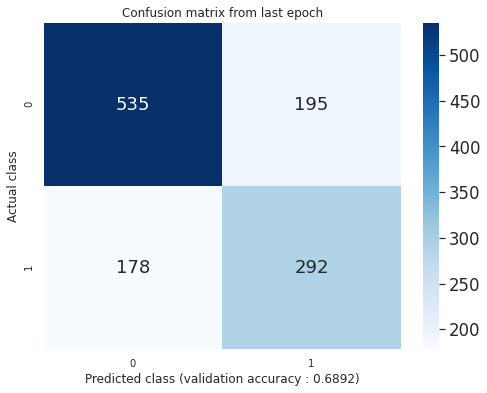

In [26]:
plot_confusion_matrix()

In [27]:
targets[:50]

tensor([0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
        0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1.],
       device='cuda:0')

In [28]:
preds[:50]

tensor([0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1.],
       device='cuda:0')

In [34]:
((t == 0).nonzero(as_tuple=True)[0])

tensor([   0,    1,    4,    5,    6,    7,    9,   11,   12,   13,   14,   15,
          18,   20,   22,   23,   24,   25,   27,   28,   31,   32,   33,   34,
          35,   38,   39,   40,   41,   42,   45,   46,   48,   54,   55,   56,
          57,   58,   59,   60,   61,   62,   63,   66,   67,   68,   69,   70,
          75,   76,   77,   80,   82,   83,   87,   91,   92,   97,   99,  102,
         103,  104,  105,  107,  109,  110,  111,  112,  113,  114,  116,  117,
         120,  124,  127,  129,  131,  132,  133,  134,  135,  136,  137,  139,
         142,  144,  146,  147,  150,  152,  153,  154,  155,  156,  157,  158,
         160,  162,  164,  167,  168,  169,  170,  172,  174,  175,  176,  178,
         179,  181,  182,  183,  185,  187,  188,  189,  192,  193,  194,  195,
         196,  198,  199,  201,  202,  203,  204,  205,  207,  210,  213,  214,
         215,  217,  218,  219,  222,  223,  226,  227,  230,  233,  234,  236,
         237,  240,  245,  246,  248,  2

In [33]:
[x.item() for x in ((t == 0).nonzero(as_tuple=True)[0])]

[0,
 1,
 4,
 5,
 6,
 7,
 9,
 11,
 12,
 13,
 14,
 15,
 18,
 20,
 22,
 23,
 24,
 25,
 27,
 28,
 31,
 32,
 33,
 34,
 35,
 38,
 39,
 40,
 41,
 42,
 45,
 46,
 48,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 66,
 67,
 68,
 69,
 70,
 75,
 76,
 77,
 80,
 82,
 83,
 87,
 91,
 92,
 97,
 99,
 102,
 103,
 104,
 105,
 107,
 109,
 110,
 111,
 112,
 113,
 114,
 116,
 117,
 120,
 124,
 127,
 129,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 139,
 142,
 144,
 146,
 147,
 150,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 160,
 162,
 164,
 167,
 168,
 169,
 170,
 172,
 174,
 175,
 176,
 178,
 179,
 181,
 182,
 183,
 185,
 187,
 188,
 189,
 192,
 193,
 194,
 195,
 196,
 198,
 199,
 201,
 202,
 203,
 204,
 205,
 207,
 210,
 213,
 214,
 215,
 217,
 218,
 219,
 222,
 223,
 226,
 227,
 230,
 233,
 234,
 236,
 237,
 240,
 245,
 246,
 248,
 250,
 251,
 252,
 253,
 254,
 256,
 257,
 258,
 260,
 262,
 266,
 269,
 270,
 271,
 272,
 273,
 274,
 276,
 279,
 280,
 281,
 283,
 286,
 288,
 293,
 294,
 295,
 296,
 297

In [37]:
preds[:50]

tensor([0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1.],
       device='cuda:0')

In [36]:
targets[:50]

tensor([0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
        0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1.],
       device='cuda:0')

In [39]:
[preds[x].item() for x in [x.item() for x in ((t == 0).nonzero(as_tuple=True)[0])]]

[0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0

In [41]:
[x.item() for x in ((t == 0).nonzero(as_tuple=True)[0])]

[0,
 1,
 4,
 5,
 6,
 7,
 9,
 11,
 12,
 13,
 14,
 15,
 18,
 20,
 22,
 23,
 24,
 25,
 27,
 28,
 31,
 32,
 33,
 34,
 35,
 38,
 39,
 40,
 41,
 42,
 45,
 46,
 48,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 66,
 67,
 68,
 69,
 70,
 75,
 76,
 77,
 80,
 82,
 83,
 87,
 91,
 92,
 97,
 99,
 102,
 103,
 104,
 105,
 107,
 109,
 110,
 111,
 112,
 113,
 114,
 116,
 117,
 120,
 124,
 127,
 129,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 139,
 142,
 144,
 146,
 147,
 150,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 160,
 162,
 164,
 167,
 168,
 169,
 170,
 172,
 174,
 175,
 176,
 178,
 179,
 181,
 182,
 183,
 185,
 187,
 188,
 189,
 192,
 193,
 194,
 195,
 196,
 198,
 199,
 201,
 202,
 203,
 204,
 205,
 207,
 210,
 213,
 214,
 215,
 217,
 218,
 219,
 222,
 223,
 226,
 227,
 230,
 233,
 234,
 236,
 237,
 240,
 245,
 246,
 248,
 250,
 251,
 252,
 253,
 254,
 256,
 257,
 258,
 260,
 262,
 266,
 269,
 270,
 271,
 272,
 273,
 274,
 276,
 279,
 280,
 281,
 283,
 286,
 288,
 293,
 294,
 295,
 296,
 297

In [42]:
[preds[x].item() for x in [x.item() for x in ((t == 0).nonzero(as_tuple=True)[0])]]

[0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0

In [38]:
rights_0 = []
rights_1 = []


t = targets

for i in [preds[x].item() for x in [x.item() for x in ((t == 0).nonzero(as_tuple=True)[0])]]:
    rights_0.append(np.where((i == 0),1,0).item())
    
print(rights_0)

acc_0 = sum(rights_0)/len(((t == 0).nonzero(as_tuple=True)[0]))

for i in [preds[x].item() for x in [x.item() for x in ((t == 1).nonzero(as_tuple=True)[0])]]:
    rights_1.append(np.where((i == 1),1,0))
    
acc_1 = sum(rights_1)/len(((t == 1).nonzero(as_tuple=True)[0]))

acc_0, acc_1

[1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

(0.7328767123287672, 0.6212765957446809)

In [ ]:
preds,

In [20]:
accuracies_0

[0.3917808219178082,
 0.6178082191780822,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.7328767123287672]

<ipython-input-18-0e594f34fade>:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.show()


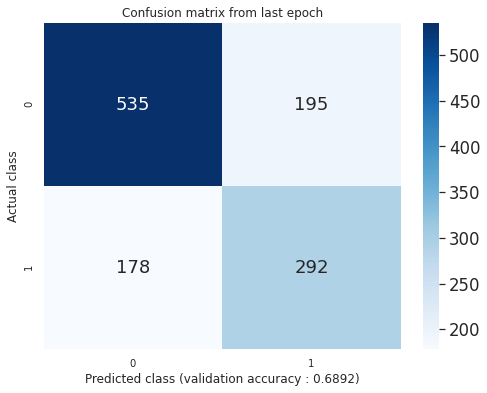

In [21]:
plot_confusion_matrix()

In [61]:
targets.detach().cpu().numpy()

array([0., 0., 1., ..., 1., 0., 1.], dtype=float32)

In [82]:
sns.heatmap(df_cm, cmap="Blues", annot=True)

NameError: name 'df_cm' is not defined

<ipython-input-74-0e594f34fade>:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.show()


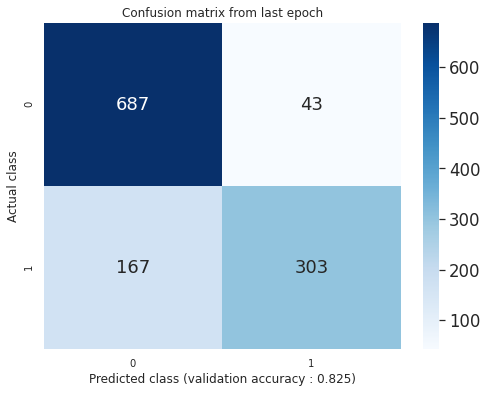

In [75]:
plot_confusion_matrix()

In [18]:
def plot_confusion_matrix():
    normalize=True
    #cmap="Blues"
    plot = plt.figure(figsize=(8,6))
    #ax = plt.subplot()
    sns.set(font_scale=1.5) # Adjust to fit
    #sns.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="g");  
    array = confusion_matrix(targets.detach().cpu().numpy(),  preds.detach().cpu().numpy())
    df_cm = pd.DataFrame(array, index = [i for i in range(2)],
                      columns = [i for i in range(2)])        

    #plt.imshow(df_cm, interpolation='nearest', cmap=cmap)

    
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['no cancer','cancer'], rotation=0, size=10)
    plt.yticks(tick_marks, ['no cancer', 'cancer'], rotation = 0, size=10)
    plt.xlabel(['no cancer', 'cancer'])

    #plt.imshowplt.show()(df_cm, interpolation='nearest', cmap=cmap)
    sns.heatmap(df_cm, cmap="Blues", annot=True, fmt='g')
    
    plt.ylabel('Actual class', fontsize=12)

    plt.xlabel(f'Predicted class (validation accuracy : {np.round(validation_acc[-1], 4)})', fontsize=12)
    plt.title(f"Confusion matrix from last epoch", fontsize =12)

    #plot.savefig(self.output_directory+'/'+'confusion_matrix.png', bbox_inches='tight', facecolor='white')

    plot.show()

In [ ]:
# Run training.

if net:
    del net

torch.cuda.empty_cache()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = models.resnet18().to(device)
train_loss, train_acc, validation_loss, validation_acc, preds, targets, accuracies_0, accuracies_1 = train(net, device, train_loader, validation_loader, 25)
tr_loss = [tl.cpu().detach().numpy() for tl in train_loss]
plot_loss_accuracy(tr_loss, train_acc, validation_loss, validation_acc)
plot_acc()
plot_confusion_matrix()

In [ ]:
### default lr = 0.0005

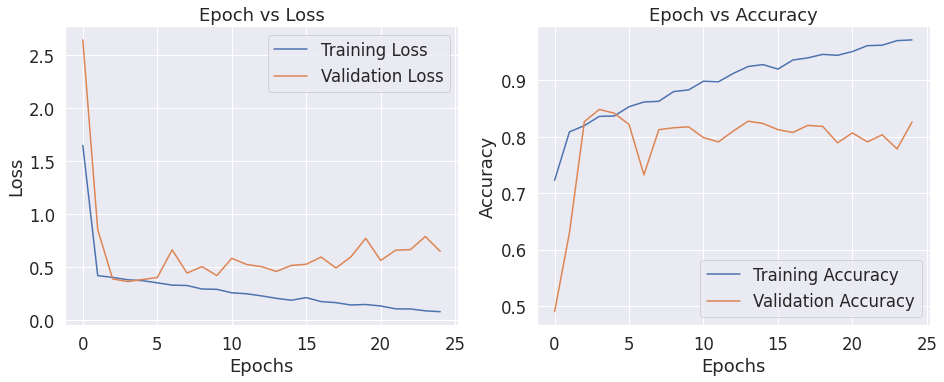

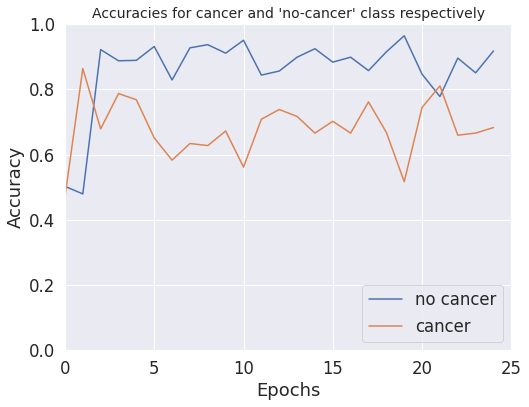

<ipython-input-26-0e594f34fade>:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.show()


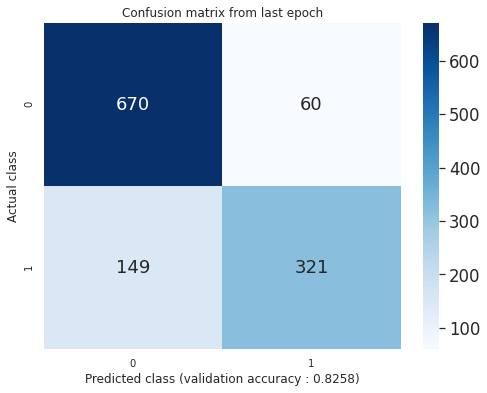

In [33]:
# Run training.

if net:
    del net

torch.cuda.empty_cache()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = models.resnet18().to(device)
train_loss, train_acc, validation_loss, validation_acc, preds, targets, accuracies_0, accuracies_1 = train(net, device, train_loader, validation_loader, 25)
tr_loss = [tl.cpu().detach().numpy() for tl in train_loss]
plot_loss_accuracy(tr_loss, train_acc, validation_loss, validation_acc)
plot_acc()
plot_confusion_matrix()

<ipython-input-23-455b4d008ca1>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


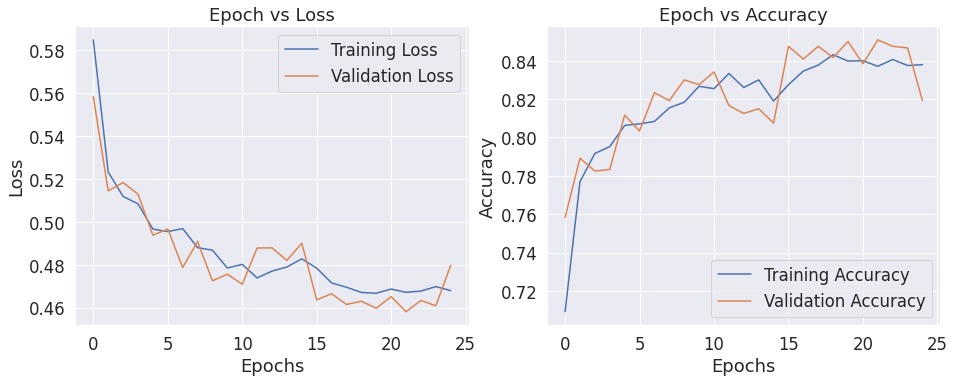

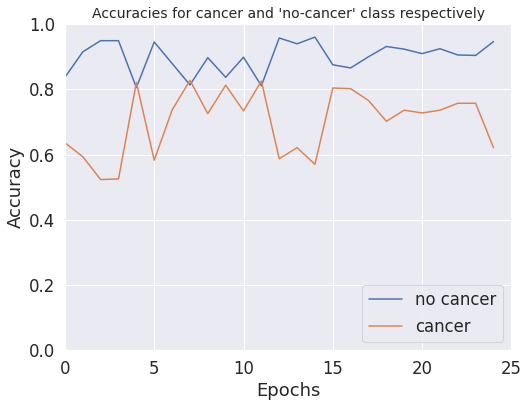

<ipython-input-26-0e594f34fade>:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.show()


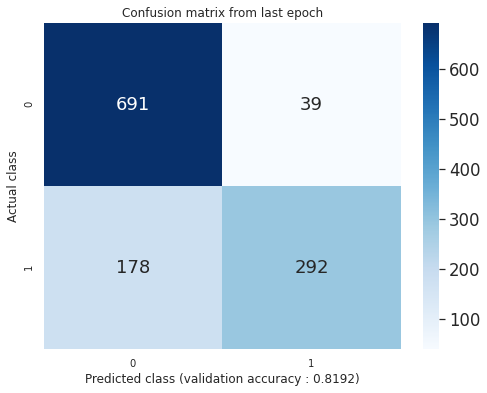

In [32]:
# Run training.

if net:
    del net

torch.cuda.empty_cache()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = conv_net().to(device)
train_loss, train_acc, validation_loss, validation_acc, preds, targets, accuracies_0, accuracies_1 = train(net, device, train_loader, validation_loader, 25)
tr_loss = [tl.cpu().detach().numpy() for tl in train_loss]
plot_loss_accuracy(tr_loss, train_acc, validation_loss, validation_acc)
plot_acc()
plot_confusion_matrix()

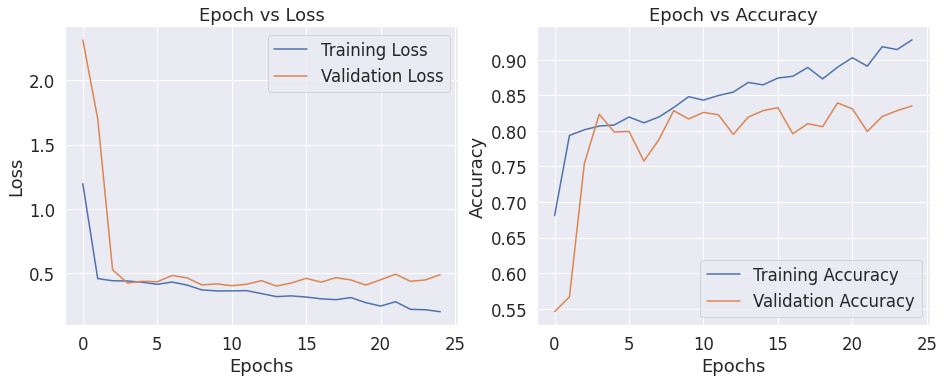

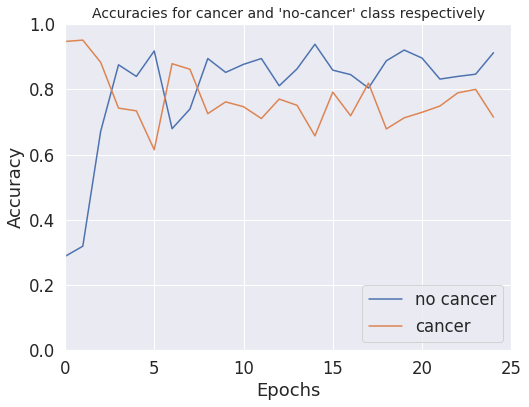

<ipython-input-26-0e594f34fade>:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.show()


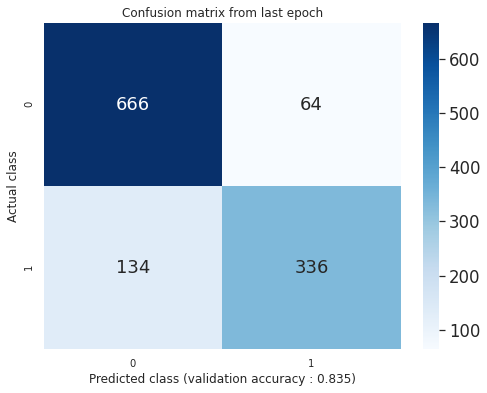

In [31]:
# Run training.

if net:
    del net

torch.cuda.empty_cache()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = models.resnet50().to(device)
train_loss, train_acc, validation_loss, validation_acc, preds, targets, accuracies_0, accuracies_1 = train(net, device, train_loader, validation_loader, 25)
tr_loss = [tl.cpu().detach().numpy() for tl in train_loss]
plot_loss_accuracy(tr_loss, train_acc, validation_loss, validation_acc)
plot_acc()
plot_confusion_matrix()

/home/alex/pytorch/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


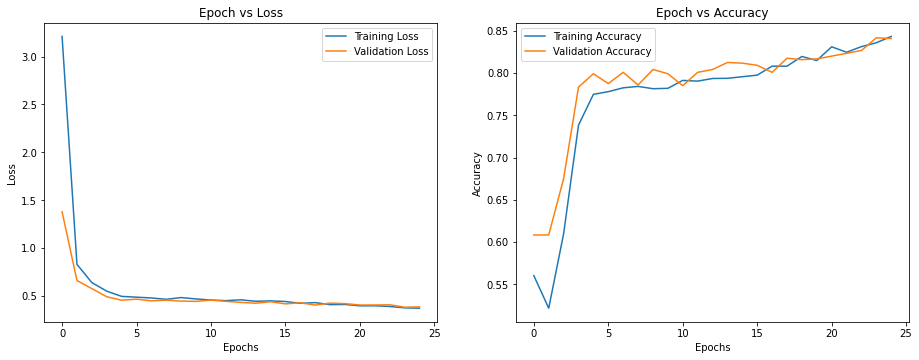

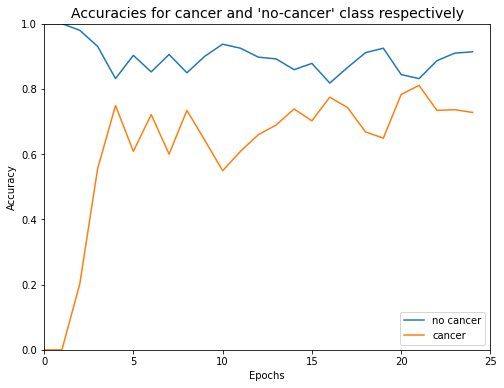

<ipython-input-26-0e594f34fade>:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.show()


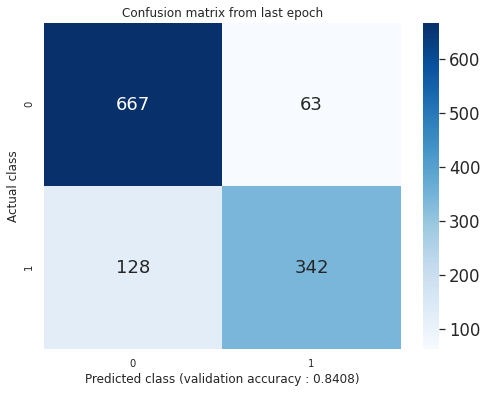

In [30]:
# Run training.

# if net:
#     del net

# torch.cuda.empty_cache()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = models.alexnet().to(device)
train_loss, train_acc, validation_loss, validation_acc, preds, targets, accuracies_0, accuracies_1 = train(net, device, train_loader, validation_loader, 25)
tr_loss = [tl.cpu().detach().numpy() for tl in train_loss]
plot_loss_accuracy(tr_loss, train_acc, validation_loss, validation_acc)
plot_acc()
plot_confusion_matrix()

In [82]:
### lr change


# Make a CNN & train it to predict genres.

class conv_net(nn.Module):
    def __init__(self):
        """Intitalize neural net layers"""
        super(conv_net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(in_features=3200, out_features=2)

        self.batchnorm1 = nn.BatchNorm2d(num_features=8)
        self.batchnorm2 = nn.BatchNorm2d(num_features=16)
        self.batchnorm3 = nn.BatchNorm2d(num_features=32)

        self.dropout = nn.Dropout(p=0.3, inplace=False)


    def forward(self, x):
        # Conv layer 1.
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        # Conv layer 2.
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        # Conv layer 3.
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        #print(x.shape)
        # Fully connected layer 1.
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = F.softmax(x)

        return x


def train(model, device, train_loader, validation_loader, epochs):
    
    preds = []
    
    accuracies_0 = []
    accuracies_1 = []

    criterion =  nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005) ### lr change
    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []
    with tqdm(range(epochs), unit='epoch') as tepochs:
        tepochs.set_description('Training')
        for epoch in tepochs:
            model.train()
            # keep track of the running loss
            running_loss = 0.
            correct, total = 0, 0

            for data, target in train_loader:
                # getting the training set
                #data = data.permute(0,3,1,2).float()
                data, target = data.to(device), target.to(device)
                #print(data.shape, target.shape)
                # Get the model output (call the model with the data from this batch)
                output = model(data)
                # Zero the gradients out)
                optimizer.zero_grad()
                # Get the Loss
                loss  = criterion(output, target)
                # Calculate the gradients
                loss.backward()
                # Update the weights (using the training step of the optimizer)
                optimizer.step()

                tepochs.set_postfix(loss=loss.item())
                running_loss += loss  # add the loss for this batch

                # get accuracy
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

            # append the loss for this epoch
            train_loss.append(running_loss/len(train_loader))
            train_acc.append(correct/total)

            # evaluate on validation data
            model.eval()
            running_loss = 0.
            correct, total = 0, 0

            targets = torch.zeros(0).to('cuda:0')
            
            preds = torch.zeros(0).to('cuda:0')
            
            for data, target in validation_loader:
                # getting the validation set
                #data = data.permute(0,3,1,2).float()
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                tepochs.set_postfix(loss=loss.item())
                running_loss += loss.item()
                # get accuracy
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

                targets = torch.cat((targets, target))
                
                preds = torch.cat((preds, predicted))
                
            validation_loss.append(running_loss/len(validation_loader))
            validation_acc.append(correct/total)
            
            rights_0 = []
            rights_1 = []


            t = targets

            for i in [preds[x].item() for x in [x.item() for x in ((t == 0).nonzero(as_tuple=True)[0])]]:
                rights_0.append(np.where((i == 0),1,0))

            acc_0 = sum(rights_0)/len(((t == 0).nonzero(as_tuple=True)[0]))

            for i in [preds[x].item() for x in [x.item() for x in ((t == 1).nonzero(as_tuple=True)[0])]]:
                rights_1.append(np.where((i == 1),1,0))

            acc_1 = sum(rights_1)/len(((t == 1).nonzero(as_tuple=True)[0]))
            
            accuracies_0.append(acc_0)
            accuracies_1.append(acc_1)

        

    return train_loss, train_acc, validation_loss, validation_acc, preds, targets, accuracies_0, accuracies_1




# Run training.

## lr=0.005

# if net:
#     del net

# torch.cuda.empty_cache()

# net = models.resnet50().to(device)
# train_loss, train_acc, validation_loss, validation_acc, preds, targets, accuracies_0, accuracies_1 = train(net, device, train_loader, validation_loader, 10)
# tr_loss = [tl.cpu().detach().numpy() for tl in train_loss]
# plot_loss_accuracy(tr_loss, train_acc, validation_loss, validation_acc)
# plot_acc()
# plot_confusion_matrix()

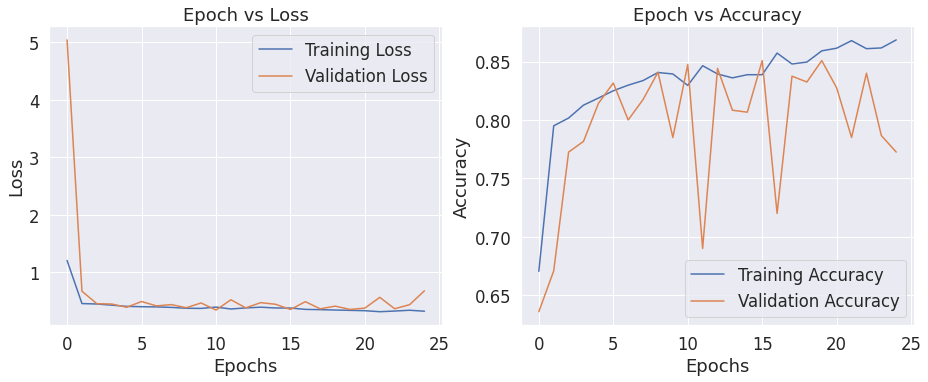

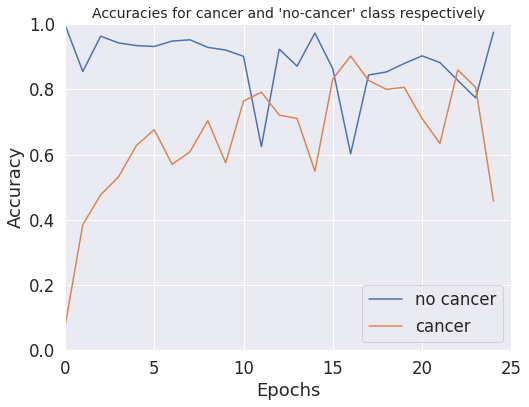

<ipython-input-26-0e594f34fade>:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.show()


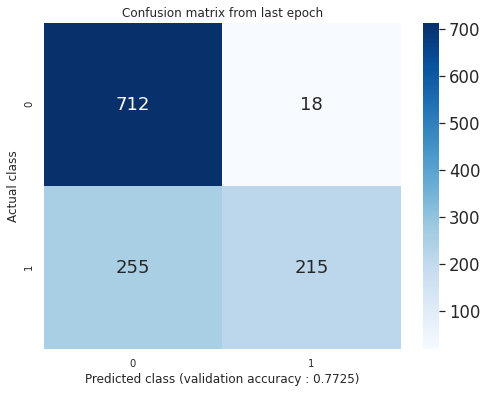

In [37]:
if net:
    del net

torch.cuda.empty_cache()

net = models.resnet18().to(device)
train_loss, train_acc, validation_loss, validation_acc, preds, targets, accuracies_0, accuracies_1 = train(net, device, train_loader, validation_loader, 25)
tr_loss = [tl.cpu().detach().numpy() for tl in train_loss]
plot_loss_accuracy(tr_loss, train_acc, validation_loss, validation_acc)
plot_acc()
plot_confusion_matrix()

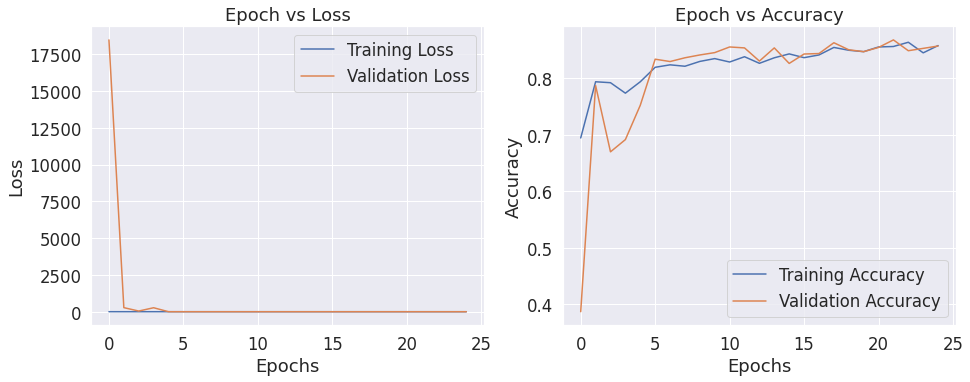

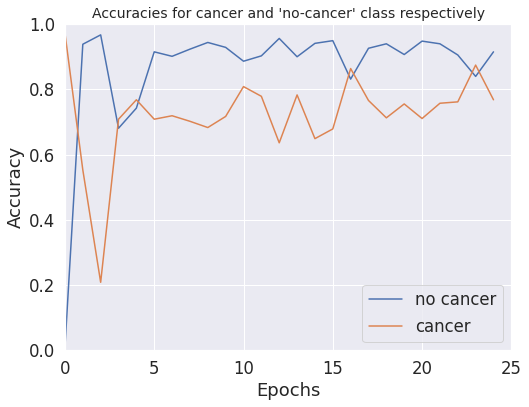

<ipython-input-26-0e594f34fade>:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.show()


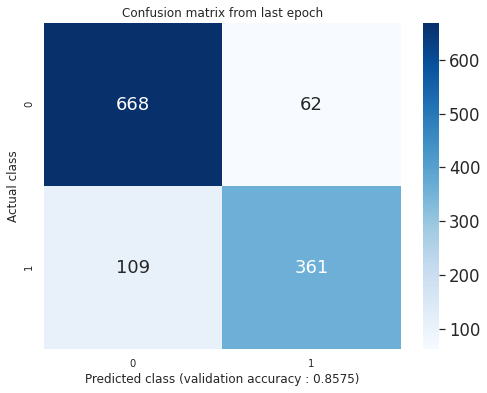

In [36]:
if net:
    del net

torch.cuda.empty_cache()

net = models.resnet50().to(device)
train_loss, train_acc, validation_loss, validation_acc, preds, targets, accuracies_0, accuracies_1 = train(net, device, train_loader, validation_loader, 25)
tr_loss = [tl.cpu().detach().numpy() for tl in train_loss]
plot_loss_accuracy(tr_loss, train_acc, validation_loss, validation_acc)
plot_acc()
plot_confusion_matrix()

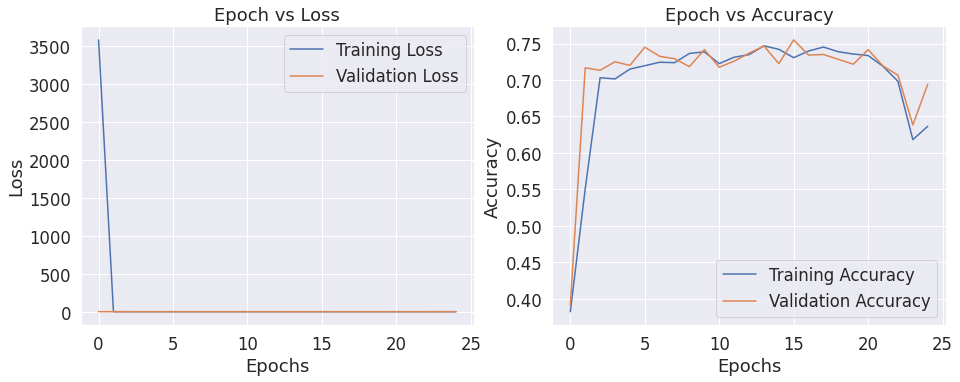

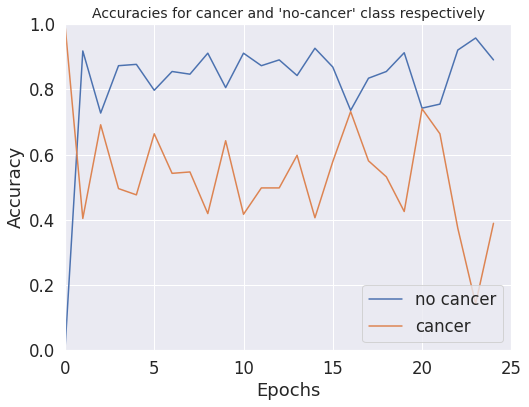

[0.0, 0.9178082191780822, 0.7273972602739726, 0.8726027397260274, 0.8767123287671232, 0.7972602739726027, 0.8547945205479452, 0.8465753424657534, 0.910958904109589, 0.8054794520547945, 0.910958904109589, 0.8726027397260274, 0.8904109589041096, 0.8424657534246576, 0.9260273972602739, 0.8684931506849315, 0.7356164383561644, 0.8342465753424657, 0.8547945205479452, 0.9123287671232877, 0.7424657534246575, 0.7547945205479452, 0.9205479452054794, 0.9575342465753425, 0.8904109589041096]


<ipython-input-74-0e594f34fade>:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.show()


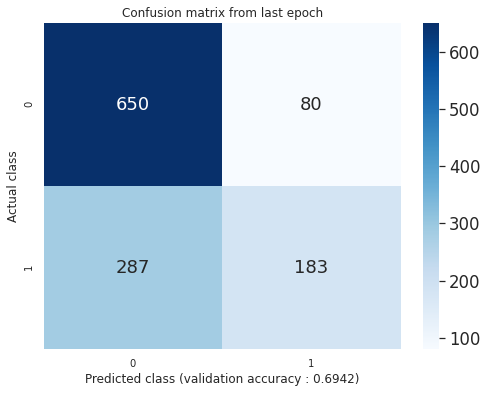

In [83]:
if net:
    del net

torch.cuda.empty_cache()

net = models.alexnet().to(device)
train_loss, train_acc, validation_loss, validation_acc, preds, targets, accuracies_0, accuracies_1 = train(net, device, train_loader, validation_loader, 25)
tr_loss = [tl.cpu().detach().numpy() for tl in train_loss]
plot_loss_accuracy(tr_loss, train_acc, validation_loss, validation_acc)
plot_acc()
plot_confusion_matrix()
print(accuracies_0)

In [85]:
from vision.models import alexnet

ModuleNotFoundError: No module named 'vision'

In [ ]:
net = 

In [ ]:
from torch.vision.models import alexnet

if net:
    del net

torch.cuda.empty_cache()

net = models.alexnet().to(device)
train_loss, train_acc, validation_loss, validation_acc, preds, targets, accuracies_0, accuracies_1 = train(net, device, train_loader, validation_loader, 25)
tr_loss = [tl.cpu().detach().numpy() for tl in train_loss]
plot_loss_accuracy(tr_loss, train_acc, validation_loss, validation_acc)
plot_acc()
plot_confusion_matrix()
print(accuracies_0)

<ipython-input-35-3c7c3437799c>:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


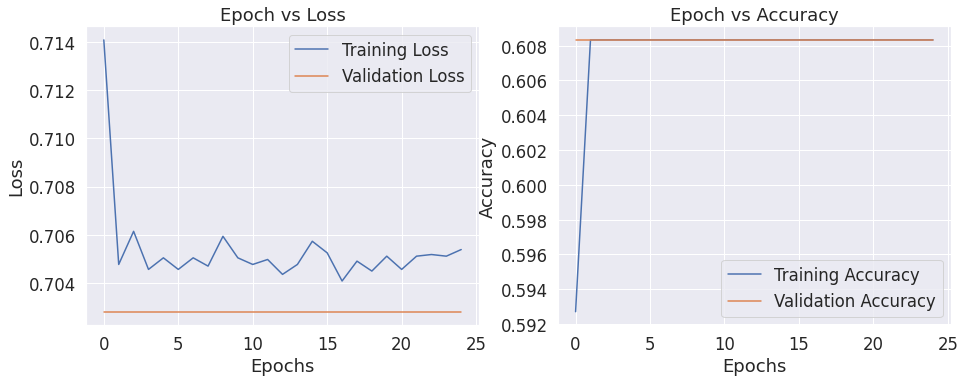

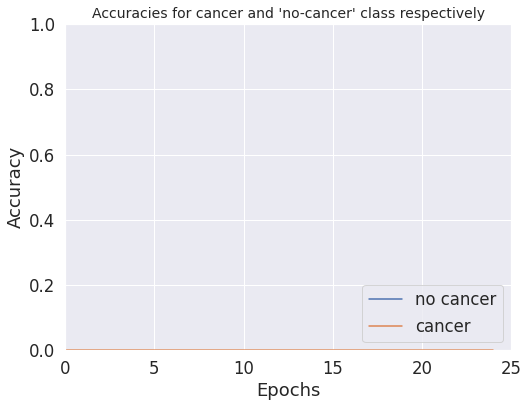

<ipython-input-26-0e594f34fade>:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.show()


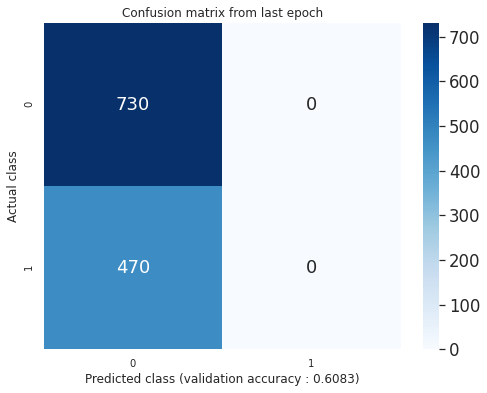

In [39]:
if net:
    del net


torch.cuda.empty_cache()

net = conv_net().to(device)
train_loss, train_acc, validation_loss, validation_acc, preds, targets, accuracies_0, accuracies_1 = train(net, device, train_loader, validation_loader, 25)
tr_loss = [tl.cpu().detach().numpy() for tl in train_loss]
plot_loss_accuracy(tr_loss, train_acc, validation_loss, validation_acc)
plot_acc()
plot_confusion_matrix()

<ipython-input-35-3c7c3437799c>:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


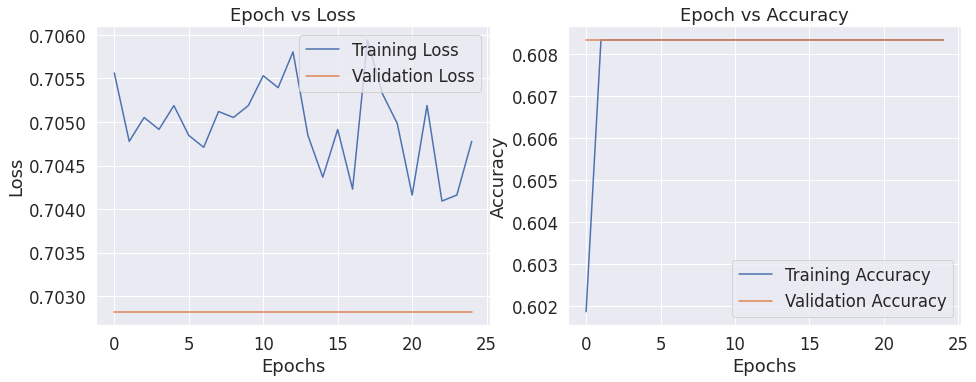

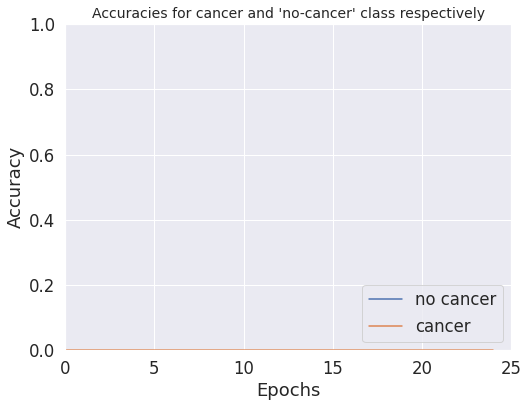

<ipython-input-26-0e594f34fade>:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.show()


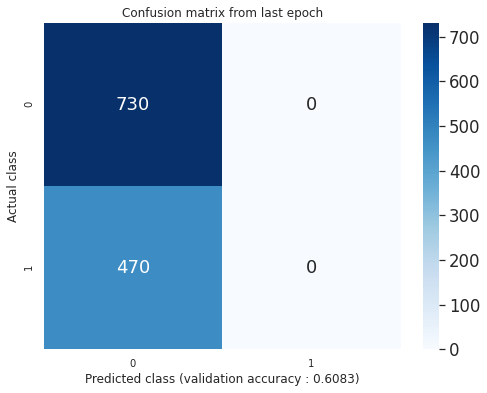

In [41]:
if net:
    del net


torch.cuda.empty_cache()

net = conv_net().to(device)
train_loss, train_acc, validation_loss, validation_acc, preds, targets, accuracies_0, accuracies_1 = train(net, device, train_loader, validation_loader, 25)
tr_loss = [tl.cpu().detach().numpy() for tl in train_loss]
plot_loss_accuracy(tr_loss, train_acc, validation_loss, validation_acc)
plot_acc()
plot_confusion_matrix()

<ipython-input-42-455b4d008ca1>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


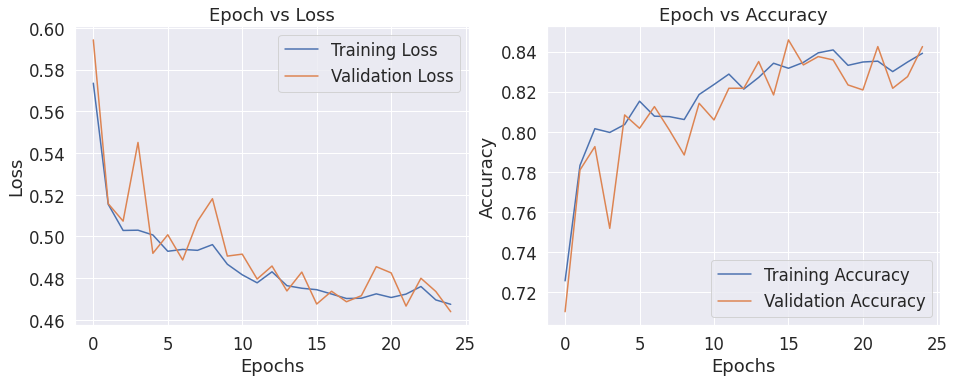

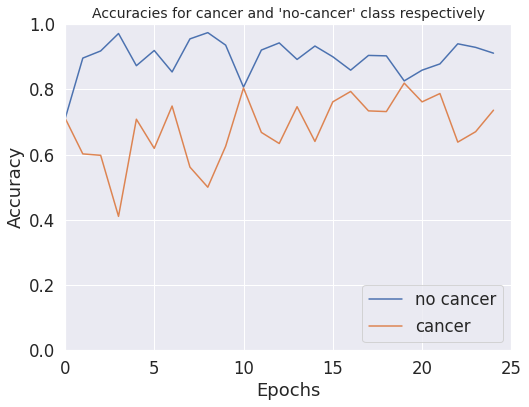

<ipython-input-26-0e594f34fade>:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.show()


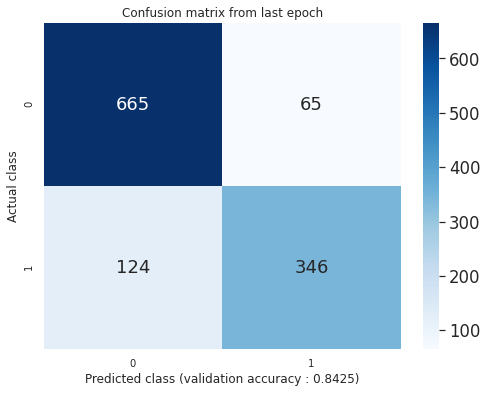

In [43]:
## normal lr


if net:
    del net


torch.cuda.empty_cache()

net = conv_net().to(device)
train_loss, train_acc, validation_loss, validation_acc, preds, targets, accuracies_0, accuracies_1 = train(net, device, train_loader, validation_loader, 25)
tr_loss = [tl.cpu().detach().numpy() for tl in train_loss]
plot_loss_accuracy(tr_loss, train_acc, validation_loss, validation_acc)
plot_acc()
plot_confusion_matrix()

<ipython-input-44-44221d50d57d>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


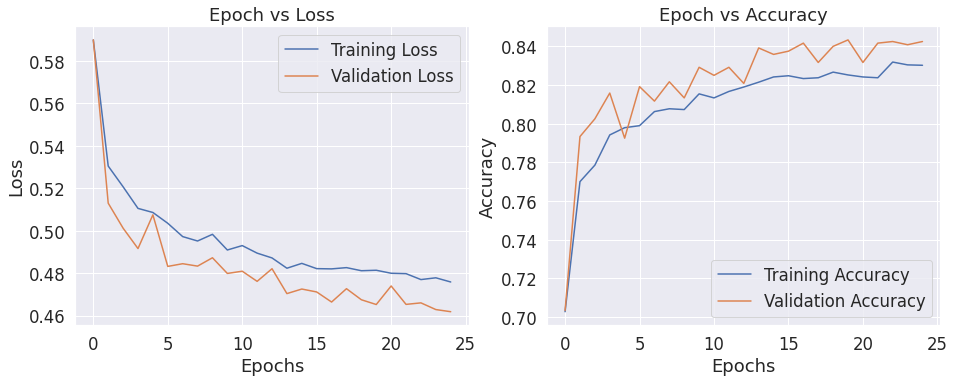

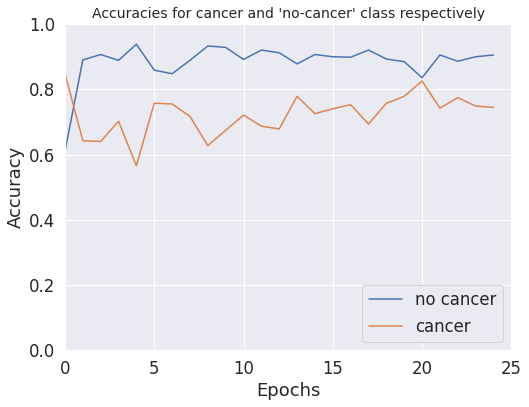

<ipython-input-26-0e594f34fade>:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.show()


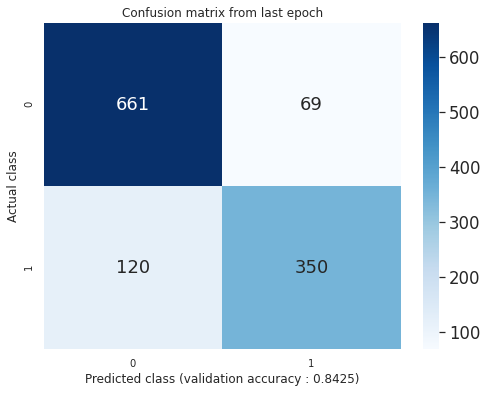

In [45]:
## normal lr, droput = 0.8 instead of 0.3

## convnet

## normal lr


if net:
    del net


torch.cuda.empty_cache()

net = conv_net().to(device)
train_loss, train_acc, validation_loss, validation_acc, preds, targets, accuracies_0, accuracies_1 = train(net, device, train_loader, validation_loader, 25)
tr_loss = [tl.cpu().detach().numpy() for tl in train_loss]
plot_loss_accuracy(tr_loss, train_acc, validation_loss, validation_acc)
plot_acc()
plot_confusion_matrix()

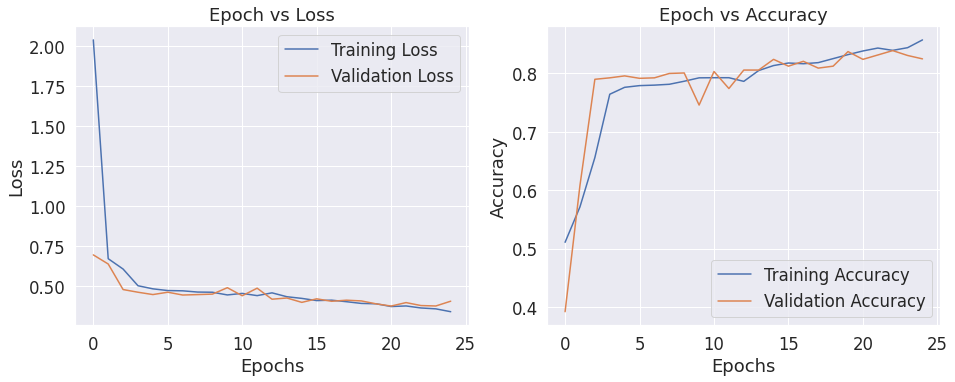

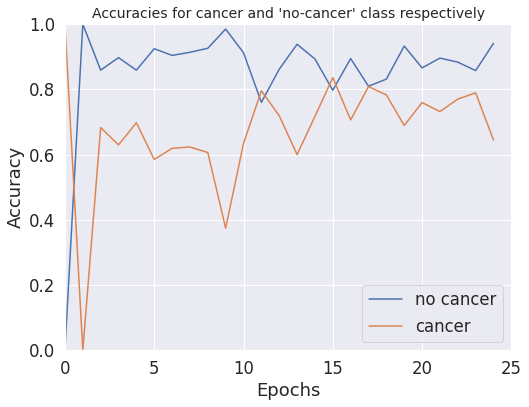

<ipython-input-26-0e594f34fade>:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.show()


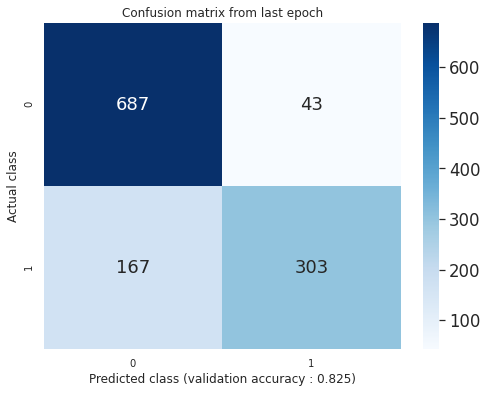

In [59]:
## increased dropout = 0.9 alexnet, normal lr 


## normal lr


if net:
    del net


torch.cuda.empty_cache()

net = alexnet().to(device)
train_loss, train_acc, validation_loss, validation_acc, preds, targets, accuracies_0, accuracies_1 = train(net, device, train_loader, validation_loader, 25)
tr_loss = [tl.cpu().detach().numpy() for tl in train_loss]
plot_loss_accuracy(tr_loss, train_acc, validation_loss, validation_acc)
plot_acc()
plot_confusion_matrix()

In [44]:
# Make a CNN & train it to predict genres.

class conv_net(nn.Module):
    def __init__(self):
        """Intitalize neural net layers"""
        super(conv_net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(in_features=3200, out_features=2)

        self.batchnorm1 = nn.BatchNorm2d(num_features=8)
        self.batchnorm2 = nn.BatchNorm2d(num_features=16)
        self.batchnorm3 = nn.BatchNorm2d(num_features=32)

        self.dropout = nn.Dropout(p=0.8, inplace=False)


    def forward(self, x):
        # Conv layer 1.
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        # Conv layer 2.
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        # Conv layer 3.
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        #print(x.shape)
        # Fully connected layer 1.
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = F.softmax(x)

        return x


def train(model, device, train_loader, validation_loader, epochs):
    
    preds = []
    
    accuracies_0 = []
    accuracies_1 = []

    criterion =  nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []
    with tqdm(range(epochs), unit='epoch') as tepochs:
        tepochs.set_description('Training')
        for epoch in tepochs:
            model.train()
            # keep track of the running loss
            running_loss = 0.
            correct, total = 0, 0

            for data, target in train_loader:
                # getting the training set
                #data = data.permute(0,3,1,2).float()
                data, target = data.to(device), target.to(device)
                #print(data.shape, target.shape)
                # Get the model output (call the model with the data from this batch)
                output = model(data)
                # Zero the gradients out)
                optimizer.zero_grad()
                # Get the Loss
                loss  = criterion(output, target)
                # Calculate the gradients
                loss.backward()
                # Update the weights (using the training step of the optimizer)
                optimizer.step()

                tepochs.set_postfix(loss=loss.item())
                running_loss += loss  # add the loss for this batch

                # get accuracy
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

            # append the loss for this epoch
            train_loss.append(running_loss/len(train_loader))
            train_acc.append(correct/total)

            # evaluate on validation data
            model.eval()
            running_loss = 0.
            correct, total = 0, 0

            targets = torch.zeros(0).to('cuda:0')
            
            preds = torch.zeros(0).to('cuda:0')
            
            for data, target in validation_loader:
                # getting the validation set
                #data = data.permute(0,3,1,2).float()
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                tepochs.set_postfix(loss=loss.item())
                running_loss += loss.item()
                # get accuracy
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

                targets = torch.cat((targets, target))
                
                preds = torch.cat((preds, predicted))
                
            validation_loss.append(running_loss/len(validation_loader))
            validation_acc.append(correct/total)
            
            rights_0 = []
            rights_1 = []


            t = targets

            for i in [preds[x].item() for x in [x.item() for x in ((t == 0).nonzero(as_tuple=True)[0])]]:
                rights_0.append(np.where((i == 0),1,0))

            acc_0 = sum(rights_0)/len(((t == 0).nonzero(as_tuple=True)[0]))

            for i in [preds[x].item() for x in [x.item() for x in ((t == 1).nonzero(as_tuple=True)[0])]]:
                rights_1.append(np.where((i == 1),1,0))

            acc_1 = sum(rights_1)/len(((t == 1).nonzero(as_tuple=True)[0]))
            
            accuracies_0.append(acc_0)
            accuracies_1.append(acc_1)

        

    return train_loss, train_acc, validation_loss, validation_acc, preds, targets, accuracies_0, accuracies_1

In [ ]:
#### early stopping



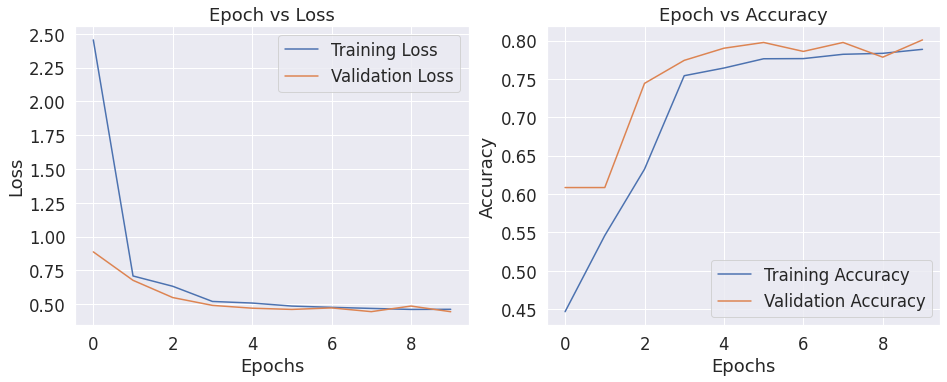

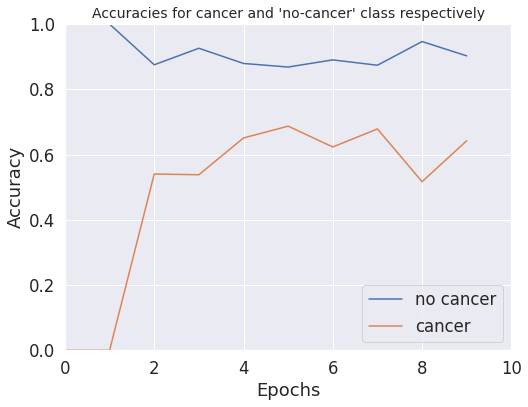

<ipython-input-101-0e594f34fade>:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.show()


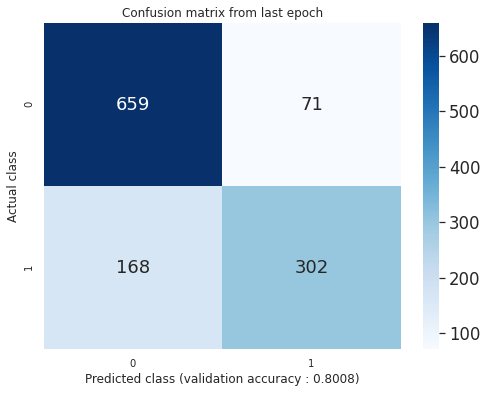

In [117]:
# Make a CNN & train it to predict genres.

class conv_net(nn.Module):
    def __init__(self):
        """Intitalize neural net layers"""
        super(conv_net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(in_features=3200, out_features=2)

        self.batchnorm1 = nn.BatchNorm2d(num_features=8)
        self.batchnorm2 = nn.BatchNorm2d(num_features=16)
        self.batchnorm3 = nn.BatchNorm2d(num_features=32)

        self.dropout = nn.Dropout(p=0.3, inplace=False)


    def forward(self, x):
        # Conv layer 1.
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        # Conv layer 2.
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        # Conv layer 3.
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        #print(x.shape)
        # Fully connected layer 1.
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc1(x)
        x = F.softmax(x)

        return x


def train(model, device, train_loader, validation_loader, epochs):
    
    preds = []
    
    accuracies_0 = []
    accuracies_1 = []

    criterion =  nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []
    with tqdm(range(epochs), unit='epoch') as tepochs:
        tepochs.set_description('Training')
        for epoch in tepochs:
            model.train()
            # keep track of the running loss
            running_loss = 0.
            correct, total = 0, 0

            for data, target in train_loader:
                # getting the training set
                #data = data.permute(0,3,1,2).float()
                data, target = data.to(device), target.to(device)
                #print(data.shape, target.shape)
                # Get the model output (call the model with the data from this batch)
                output = model(data)
                # Zero the gradients out)
                optimizer.zero_grad()
                # Get the Loss
                loss  = criterion(output, target)
                # Calculate the gradients
                loss.backward()
                # Update the weights (using the training step of the optimizer)
                optimizer.step()

                tepochs.set_postfix(loss=loss.item())
                running_loss += loss  # add the loss for this batch

                # get accuracy
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

            # append the loss for this epoch
            train_loss.append(running_loss/len(train_loader))
            train_acc.append(correct/total)

            # evaluate on validation data
            model.eval()
            running_loss = 0.
            correct, total = 0, 0

            targets = torch.zeros(0).to('cuda:0')
            
            preds = torch.zeros(0).to('cuda:0')
            
            for data, target in validation_loader:
                # getting the validation set
                #data = data.permute(0,3,1,2).float()
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                tepochs.set_postfix(loss=loss.item())
                running_loss += loss.item()
                # get accuracy
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

                targets = torch.cat((targets, target))
                
                preds = torch.cat((preds, predicted))
                
            validation_loss.append(running_loss/len(validation_loader))
            validation_acc.append(correct/total)
            
            rights_0 = []
            rights_1 = []


            t = targets

            for i in [preds[x].item() for x in [x.item() for x in ((t == 0).nonzero(as_tuple=True)[0])]]:
                rights_0.append(np.where((i == 0),1,0))

            acc_0 = sum(rights_0)/len(((t == 0).nonzero(as_tuple=True)[0]))

            for i in [preds[x].item() for x in [x.item() for x in ((t == 1).nonzero(as_tuple=True)[0])]]:
                rights_1.append(np.where((i == 1),1,0))

            acc_1 = sum(rights_1)/len(((t == 1).nonzero(as_tuple=True)[0]))
            
            accuracies_0.append(acc_0)
            accuracies_1.append(acc_1)

        

    return train_loss, train_acc, validation_loss, validation_acc, preds, targets, accuracies_0, accuracies_1




# Run training.

## lr=0.005

if net:
    del net

torch.cuda.empty_cache()

net = models.alexnet().to(device)
train_loss, train_acc, validation_loss, validation_acc, preds, targets, accuracies_0, accuracies_1 = train(net, device, train_loader, validation_loader, 10)
tr_loss = [tl.cpu().detach().numpy() for tl in train_loss]
plot_loss_accuracy(tr_loss, train_acc, validation_loss, validation_acc)
plot_acc()
plot_confusion_matrix()

In [ ]:
# Run training.

if net:
    del net

torch.cuda.empty_cache()

net = models.resnet50().to(device)
train_loss, train_acc, validation_loss, validation_acc, preds, targets, accuracies_0, accuracies_1 = train(net, device, train_loader, validation_loader, 10)
tr_loss = [tl.cpu().detach().numpy() for tl in train_loss]
plot_loss_accuracy(tr_loss, train_acc, validation_loss, validation_acc)
plot_acc()
plot_confusion_matrix()

In [250]:
accuracies_1

[0.7893617021276595,
 0.7659574468085106,
 0.725531914893617,
 0.776595744680851,
 0.7574468085106383,
 0.7319148936170212,
 0.7191489361702128,
 0.7042553191489361,
 0.823404255319149,
 0.7723404255319148]

In [249]:
accuracies_0

[0.8506849315068493,
 0.8602739726027397,
 0.873972602739726,
 0.8534246575342466,
 0.873972602739726,
 0.8794520547945206,
 0.8547945205479452,
 0.915068493150685,
 0.815068493150685,
 0.8780821917808219]

In [58]:
targets.shape

torch.Size([1200])

In [65]:
for i in preds:
    print(len(preds[9]))

176
176
176
176
176
176
176
176
176
176


In [59]:
torch.cat(preds)

tensor([0, 1, 1,  ..., 1, 0, 0], device='cuda:0')

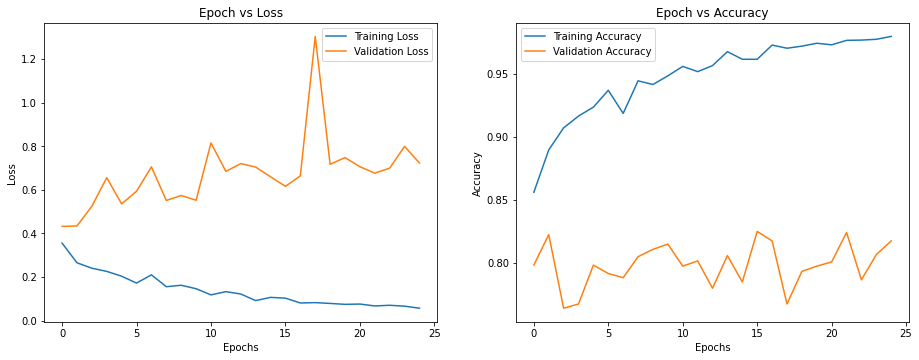

In [89]:
plot_loss_accuracy(tr_loss, train_acc, validation_loss, validation_acc)

<ipython-input-65-6cb70f63350e>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


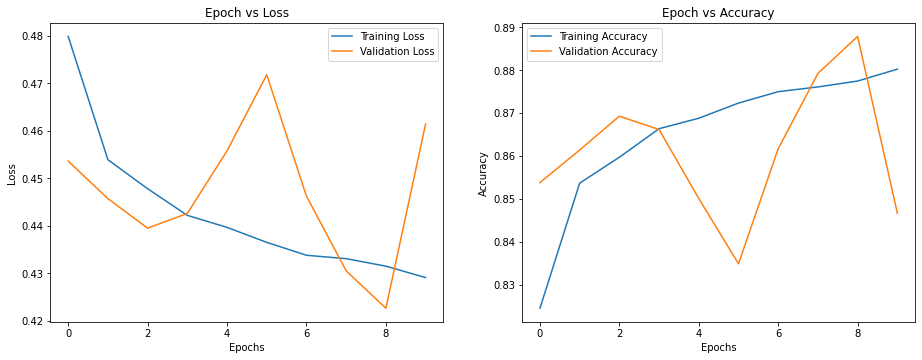

In [67]:
# Run training.

net = conv_net().to(device)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, valid_loader, 10)
tr_loss = [tl.cpu().detach().numpy() for tl in train_loss]
plot_loss_accuracy(tr_loss, train_acc, validation_loss, validation_acc)

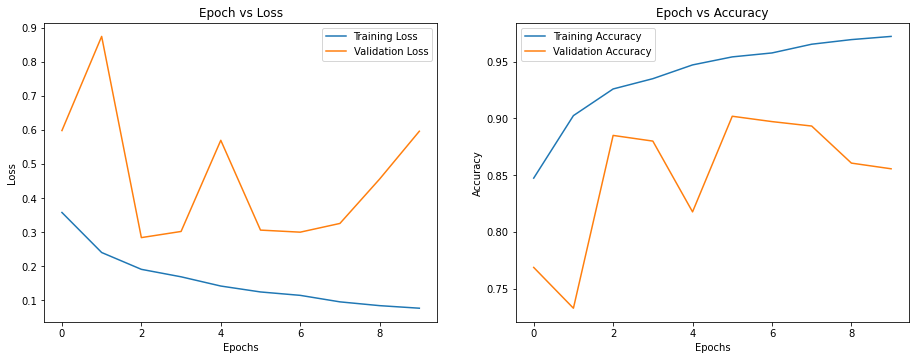

In [21]:
net = ResNet50(img_channel=3, num_classes=2).to(device)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, valid_loader, 10)
tr_loss = [tl.cpu().detach().numpy() for tl in train_loss]
plot_loss_accuracy(tr_loss, train_acc, validation_loss, validation_acc)

In [ ]:
net = ResNet50(img_channel=3, num_classes=2).to(device)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, valid_loader, 10)
tr_loss = [tl.cpu().detach().numpy() for tl in train_loss]
plot_loss_accuracy(tr_loss, train_acc, validation_loss, validation_acc)

In [22]:
torch.cuda.empty_cache()

In [ ]:
# Run training.

net = conv_net().to(device)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, valid_loader, 10)
tr_loss = [tl.cpu().detach().numpy() for tl in train_loss]
plot_loss_accuracy(tr_loss, train_acc, validation_loss, validation_acc)

In [32]:
# Run training.

net = conv_net().to(device)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, valid_loader, 10)
tr_loss = [tl.cpu().detach().numpy() for tl in train_loss]
plot_loss_accuracy(tr_loss, train_acc, validation_loss, validation_acc)

<ipython-input-31-6cb70f63350e>:43: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


NameError: name 'plot_loss_accuracy' is not defined

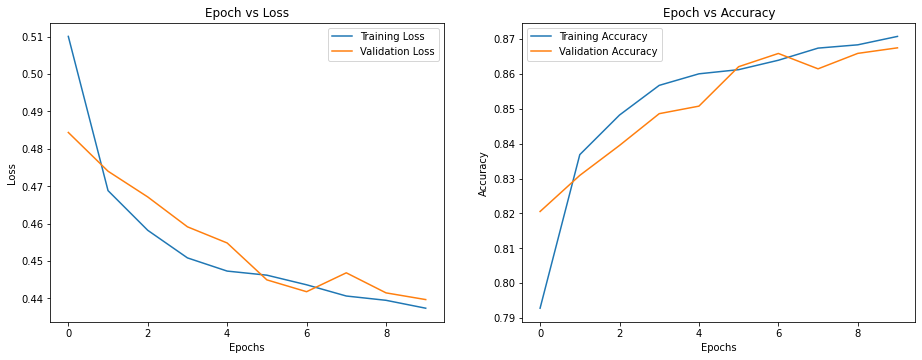

In [34]:
plot_loss_accuracy(tr_loss, train_acc, validation_loss, validation_acc)

In [62]:
def train_test_classification(net, criterion, optimizer, train_loader,
                              test_loader, num_epochs=1, verbose=True,
                              training_plot=False, device='cpu'):

    net.train()
    training_losses = []
    for epoch in tqdm(range(num_epochs)):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device).float()
            labels = labels.to(device).long()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            if verbose:
                training_losses += [loss.item()]

    net.eval()
    def test(data_loader):
        correct = 0
        total = 0
        for data in data_loader:
            inputs, labels = data
            inputs = inputs.to(device).float()
            labels = labels.to(device).long()

            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        acc = 100 * correct / total
        return total, acc

    train_total, train_acc = test(train_loader)
    test_total, test_acc = test(test_loader)

    if verbose:
        print(f"Accuracy on the {train_total} training samples: {train_acc:0.2f}")
        print(f"Accuracy on the {test_total} testing samples: {test_acc:0.2f}")

    if training_plot:
        plt.plot(training_losses)
        plt.xlabel('Batch')
        plt.ylabel('Training loss')
        plt.show()

    return train_acc, test_acc

In [64]:
set_seed(SEED)
net = model.to(device)#, X_train.shape[1], [128], K).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)
num_epochs = 5

_, _ = train_test_classification(net, criterion, optimizer, train_loader,
                                 test_loader, num_epochs=num_epochs,
                                 training_plot=True, device=device)

Random seed 4170016563 has been set.


TypeError: 'list' object is not callable

In [ ]:
# -*- coding: utf-8 -*-
"""
From scratch implementation of the famous ResNet models.
The intuition for ResNet is simple and clear, but to code
it didn't feel super clear at first, even when reading Pytorch own
implementation. 
Video explanation: 
Got any questions leave a comment on youtube :)
Programmed by Aladdin Persson <aladdin.persson at hotmail dot com>
*    2020-04-12 Initial coding
"""

import torch
import torch.nn as nn


class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super(block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels, intermediate_channels, kernel_size=1, stride=1, padding=0, bias=False
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)


def ResNet50(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)


def ResNet101(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 4, 23, 3], img_channel, num_classes)


def ResNet152(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 8, 36, 3], img_channel, num_classes)


def test():
    net = ResNet101(img_channel=3, num_classes=1000)
    y = net(torch.randn(4, 3, 224, 224)).to("cuda")
    print(y.size())


test()

Random seed 1751002438 has been set.



Accuracy on the 176020 training samples: 98.20
Accuracy on the 44005 testing samples: 96.78


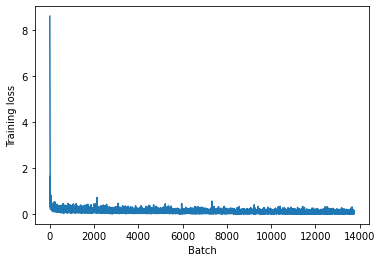

In [38]:
set_seed(SEED)
net = model.to(device)#, X_train.shape[1], [128], K).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)
num_epochs = 5

_, _ = train_test_classification(net, criterion, optimizer, train_loader,
                                 test_loader, num_epochs=num_epochs,
                                 training_plot=True, device=device)